
Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

Training final model on the full training dataset...

Test Set Metrics: F1=0.5578, F1 Weighted=0.9015, Precision=0.5697, Recall=0.5463
Validation Set Metrics: F1=0.5748, F1 Weighted=0.9090, Precision=0.6370, Recall=0.5237


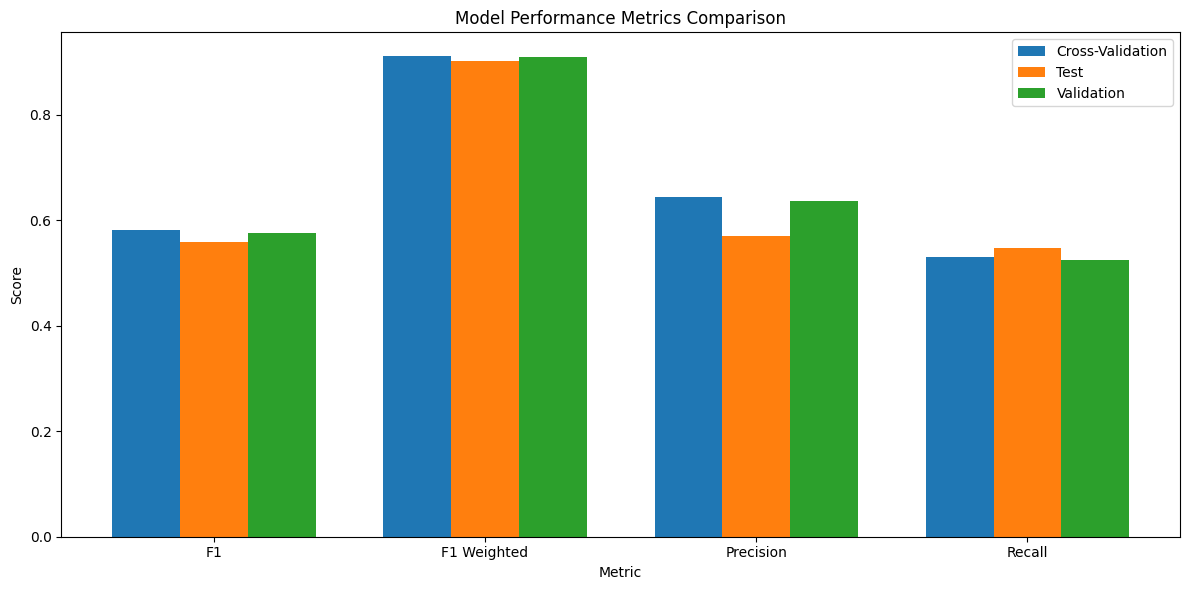

In [2]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
BASE_PATH = os.path.abspath('..')
PROCESSED_DATA_PATH = os.path.join(BASE_PATH, 'data', 'processed')
MODEL_PATH = os.path.join(BASE_PATH, 'models')

# Define file names
X_TRAIN = 'X_train.csv'
Y_TRAIN = 'y_train.csv'
X_TEST = 'X_test.csv'
Y_TEST = 'y_test.csv'
X_VALID = 'X_valid.csv'
Y_VALID = 'y_valid.csv'

# Set random seed for reproducibility
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

# Load the preprocessed data
X_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_TRAIN))
y_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_TRAIN)).values.ravel()
X_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_TEST))
y_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_TEST)).values.ravel()
X_valid = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_VALID))
y_valid = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_VALID)).values.ravel()

# Define XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'logloss',
    'random_state': RANDOM_SEED
}

# Initialize StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

# Arrays to store metrics for each fold
f1_scores, f1_weighted_scores = [], []
precision_scores, recall_scores = [], []

# Cross-validation loop
for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print(f"\nFold {fold + 1}/{n_splits}")

    X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

    # Train model
    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(X_fold_train, y_fold_train, eval_set=[(X_fold_test, y_fold_test)], verbose=False)

    # Predict
    y_pred = xgb_model.predict(X_fold_test)

    # Metrics
    f1 = f1_score(y_fold_test, y_pred, average='binary')
    f1_weighted = f1_score(y_fold_test, y_pred, average='weighted')
    precision = precision_score(y_fold_test, y_pred, average='binary')
    recall = recall_score(y_fold_test, y_pred, average='binary')

    # Store metrics
    f1_scores.append(f1)
    f1_weighted_scores.append(f1_weighted)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calculate average metrics
mean_f1, std_f1 = np.mean(f1_scores), np.std(f1_scores)
mean_f1_weighted = np.mean(f1_weighted_scores)
mean_precision, std_precision = np.mean(precision_scores), np.std(precision_scores)
mean_recall, std_recall = np.mean(recall_scores), np.std(recall_scores)

# Train final model
print("\nTraining final model on the full training dataset...")
xgb_model_final = xgb.XGBClassifier(**xgb_params)
xgb_model_final.fit(X_train, y_train)

# Predictions on test and validation sets
y_pred_test = xgb_model_final.predict(X_test)
y_pred_valid = xgb_model_final.predict(X_valid)

# Metrics for test and validation sets
test_f1 = f1_score(y_test, y_pred_test, average='binary')
test_f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
test_precision = precision_score(y_test, y_pred_test, average='binary')
test_recall = recall_score(y_test, y_pred_test, average='binary')

valid_f1 = f1_score(y_valid, y_pred_valid, average='binary')
valid_f1_weighted = f1_score(y_valid, y_pred_valid, average='weighted')
valid_precision = precision_score(y_valid, y_pred_valid, average='binary')
valid_recall = recall_score(y_valid, y_pred_valid, average='binary')

# Print metrics summary
print(f"\nTest Set Metrics: F1={test_f1:.4f}, F1 Weighted={test_f1_weighted:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}")
print(f"Validation Set Metrics: F1={valid_f1:.4f}, F1 Weighted={valid_f1_weighted:.4f}, Precision={valid_precision:.4f}, Recall={valid_recall:.4f}")

# Plot Model Performance Metrics Comparison
metrics_data = {
    'Metric': ['F1', 'F1 Weighted', 'Precision', 'Recall'],
    'Cross-Validation': [mean_f1, mean_f1_weighted, mean_precision, mean_recall],
    'Test': [test_f1, test_f1_weighted, test_precision, test_recall],
    'Validation': [valid_f1, valid_f1_weighted, valid_precision, valid_recall]
}
metrics_df = pd.DataFrame(metrics_data)

plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(4)

plt.bar(index, metrics_df['Cross-Validation'], bar_width, label='Cross-Validation')
plt.bar(index + bar_width, metrics_df['Test'], bar_width, label='Test')
plt.bar(index + 2 * bar_width, metrics_df['Validation'], bar_width, label='Validation')

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance Metrics Comparison')
plt.xticks(index + bar_width, metrics_df['Metric'])
plt.legend()
plt.tight_layout()
plt.show()
